# Simulating shockwaves and partial differential equations

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [8]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
def fixed_aspect_ratio(ratio, ax=None, log=False, semilogy=False, semilogx=False):
    """
    Set a fixed aspect ratio on matplotlib plots regardless of the axis units
    """
    if not ax:
        ax = plt.gca()
    xvals, yvals = ax.axes.get_xlim(), ax.axes.get_ylim()
    xrange = np.abs(xvals[1] - xvals[0])
    yrange = np.abs(yvals[1] - yvals[0])
    if log:
        xrange = np.log10(xvals[1]) - np.log10(xvals[0])
        yrange = np.log10(yvals[1]) - np.log10(yvals[0])
    if semilogy:
        yrange = np.log10(yvals[1]) - np.log10(yvals[0])
    if semilogx:
        xrange = np.log10(xvals[1]) - np.log10(xvals[0])
    try:
        ax.set_aspect(ratio*(xrange/yrange), adjustable='box')
    except NotImplementedError:
        warnings.warn("Setting aspect ratio is experimental for 3D plots.")
        plt.gca().set_box_aspect((1, 1, ratio*(xrange/yrange)))
        #ax.set_box_aspect((ratio*(xrange/yrange), 1, 1))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ODEs vs PDEs

+ For ODEs you can usually get away with using built-in integration functions, unless you have a special type of equation (delay, integro-differential, etc.)

+ In my experience, you rarely have the same luck with PDEs. You usually have to write your own discretization or solver. 

+ If you are solving a very common PDE (Navier Stokes, Laplace, etc.) there might be external libraries that work in certain regimes, or which can help with meshing, etc. But even in very restricted regimes, the design of these tools is expensive and narrow (using Ansys, COMSOL, etc. is a whole specialization in itself)

There are several types of PDEs, elliptical, hyperbolic, and parabolic.

| Type     | Equation | Example     |
| :---        |    :----:   |    :----:   |
| Elliptical      | $u'' + u'' = 0$      | Laplace's equation      |
| Hyperbolic      | $\ddot{u} = u''$       | Wave equation      |
| Parabolic      | $\dot{u} = u''$       | Heat equation      |

where $u' = \frac{\partial u}{\partial x}$ and $\dot{u} = \frac{\partial u}{\partial t}$ in the table





In order to demonstrate the connections between simulating ODEs and simulating ODES, we will first implement an ODE solver, similar to the ones used in previous lectures.

We will structure this code with a base class `BaseFixedStepIntegrator` that will be inherited by specific solvers. This will allow us to easily switch between different solvers in the future.

We'll test out integrator by integrating a simple ODE, a pendulum

In [9]:
## Define a fixed step integrator (solve_ivp uses adaptive step size)

class BaseFixedStepIntegrator:
    """
    A base class for fixed-step integration methods.
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y0, t_eval=None):
        """
        Integrate the ODE y' = f(t, y) from t0 to tf using an integrator's update method
        """
        t0, tf = tspan

        # Create an array of time points to evaluate the solution
        t_sol = np.arange(t0, tf, self.dt)

        # Create an array to store the solution (pre-allocate)
        y = np.zeros((len(t_sol), len(y0)))

        # Set the initial condition
        y[0] = y0

        # Integrate the ODE
        for i in range(1, len(t_sol)):
             # this will be defined in the subclass:
            y[i] = self.update(f, t_sol[i - 1], y[i - 1])

        ## Resample the solution in y to match t_eval
        if t_eval:
            y_eval = np.interp(t_eval, t_sol, y)
            self.t, self.y = t_eval, y_eval
        else:
            self.t, self.y = t_sol, y
        return self

    def update(self, f, t, y):
        """
        Update the solution using the integrator's method
        """
        raise NotImplementedError("This method must be implemented in a subclass")
        


class RK4(BaseFixedStepIntegrator):
    """
    The 4th order Runge-Kutta integration scheme
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        k3 = f(t + self.dt / 2, y + self.dt * k2 / 2)
        k4 = f(t + self.dt, y + self.dt * k3)
        return y + self.dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

Text(0, 0.5, 'Angle')

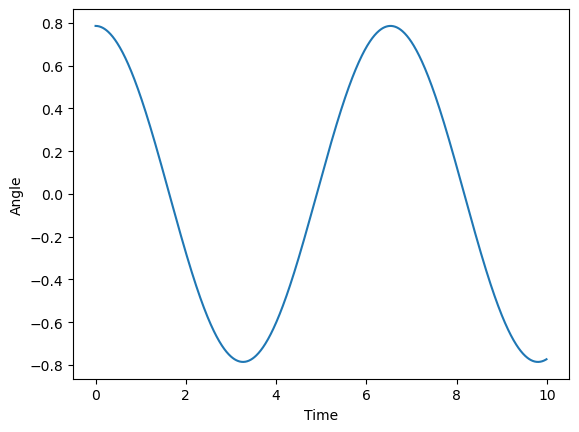

In [12]:
## Test the integrator on a simple ODE

def pendulum(t, y):
    """
    The ODE describing a simple pendulum.
    """
    theta, omega = y
    return np.array([omega, -np.sin(theta)])

# Set the initial conditions
y0 = np.array([np.pi / 4, 0])

# Set the time span
tspan = [0, 10]

# Create the integrator\
integrator = RK4(dt=1e-2)

# Integrate the ODE
integrator.integrate(pendulum, tspan, y0)

# Plot the solution
plt.plot(integrator.t, integrator.y[:, 0])
plt.xlabel("Time")
plt.ylabel("Angle")



# We next need to consider boundary conditions

+ The boundary conditions are the conditions on the solution at the edges of the domain, which includes both *space* and *time* for PDEs. In this sense, boundary conditions generalize the initial conditions we need to integrate ODEs.

+ The boundary conditions are usually specified as functions of the integration variable(s) (like concentration or probability) as a function of the domain variables (e.g. starting or ending time, or position along an edge of the domain)

+ In a *boundary value problem*, we specify the boundary conditions as $u(\mathbf{x}, t) = u_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$, where $\Omega$ denotes our solution domain (square, disk, etc). These are known as *Dirichlet* boundary conditions, where we specify the value of $u$ at the boundary.

+ We can also have *Neumann* boundary conditions, where we instead specify the value of the derivative of $u$ at the boundary. For example, we could specify $\nabla u(\mathbf{x}, t) \cdot \mathbf{\hat{t}} = f_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$, where $\mathbf{\hat{t}}$ is a unit vector normal to the boundary. This type of boundary condition specifies a fixed flux of the scalar field through the boundary.

+ We can also have *mixed* or Robin boundary conditions, where we specify a combination of Dirichlet and Neumann boundary conditions. $u(\mathbf{x}, t) + \nabla u(\mathbf{x}, t) \cdot \mathbf{\hat{t}}  = g_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$.



<!-- ## The Diffusion Equation

+ A differential equation that is often used to model the diffusion of a quantity through a medium
+ Appears in many contexts, including heat transfer, fluid flow, diffusion of molecules
+ Even the Schrodinger equation is a special case of the diffusion equation
+ Given a scalar field $\rho(x)$, the diffusion equation is

$$\frac{\partial \rho}{\partial t} = \nabla^2 \rho$$
 -->


# Burgers' equation

+ A nonlinear partial differential equation describing the time evolution of a the speed $u(x, t)$ of a fluid. This is a toy model of how steep waves form in shallow water in the ocean

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}$$

+ We will solve this equation on a 1D domain of length $L$, so $x \in [0, L]$

+ This is a one-dimensional partial differential equation. The integration variable is $u(x,t)$, and the domain variables are $x, t$.

+ The solutions tend to evolve towards shocks, which are discontinuities in the velocity. 

+  and so our boundary conditions and initial conditions will consist of: the initial value of the field $u(x, 0)$ and a condit


#  Semi-discretization: The Method of lines

+ Discretize the domain using finite differences, spectral projection, or something else, and then solve the resulting set of coupled ODEs in continuous time using a built-in ODE solver

+ The semi-discretized PDE becomes a set of coupled ODEs, which we numerically solve in continuous time

+ The semi-discretized PDE is usually solved using a built-in ODE solver. We therefore separate *meshing* (dealing with the domain) from *timestepping* (evolving forward in time)


## One possible discretization scheme: Finite difference operators

The finite difference operators are the operators that we use to approximate the derivatives in the PDE

The central first-order finite difference operators in 1D has the form

$$\frac{\partial}{\partial x} u\approx \frac{u(x + \Delta x / 2) - u(x - \Delta x / 2)}{\Delta x}$$

The central second-order finite difference operators in 1D has the form

$$\frac{\partial^2}{\partial x^2} u\approx \frac{u(x + \Delta x) - 2 u(x) + u(x - \Delta x)}{\Delta x^2}$$

## Semi-discretized Burgers' equation

Using the finite-different approximations to approximate the spatial derivatives, Burgers' equation becomes

$$
    \frac{\partial u(x, t)}{\partial t} \approx \frac{u(x + \Delta x, t) - 2 u(x, t) + u(x - \Delta x, t)}{\Delta x^2} - u(x, t) \frac{u(x + \Delta x, t) - u(x - \Delta x, t)}{2 \Delta x}
$$

We have a *hyperparameter* to set, which is the number $N$ of spatial points that we use to discretize the domain. $\Delta x \equiv L / N$. After performing this discretization, the field variable becomes $\mathbf{u}(t) \in \mathbb{R}^N$

We can therefore write Burgers' equation as a multivariate ODE, taking advantage of the fact that $u(x + \Delta x, t)$ corresponds to the next index into the vector $\mathbf{u}(t)$

$$
    \frac{\partial u_i(t)}{\partial t} \approx \frac{1}{\Delta x^2 } \bigg( u_{i+1}(t) - 2 u_{i}(t) + u_{i-1}(t)\bigg) - u(t) \frac{1}{2 \Delta x}\bigg(    u_{i+1}(t) - u_{i-1}(t)    \bigg)
$$


### Boundary conditions

What happens when we get to the last value of the array? We can't look up $u_{i+1}(t)$ if $i = L$. We now need to define, physically, what happens at the edges of our domain.

**Periodic boundary conditions** are simple to implement, but are not usually well-motived physically. The involve setting the condition that $u_{L+1}(t) = u_{0}(t)$, and that $u_{-1}(t) = u_{L}(t)$

**Dirichlet boundary conditions** describe many physical systems, but may be less stable numerically. The involve setting a fixed value, like $u_{L+1}(t) = 0$, and $u_{-1}(t) = 0$

**Neumann boundary conditions** are also very physical, and here they lead to mirror boundary conditions, where the walls of the domain reflect oncoming shocks. Since these involve conditions on the first derivative of the field with respect to space, we have to set these in terms of finite differences: $u_{L+1}(t) - u_{L-1}(t) = 0$, which is equivalent to the reflection symmetry $u_{L+1}(t) = u_{L-1}(t)$. The same goes for the other side of the domain, $u_{-1}(t) = u_{1}(t)$

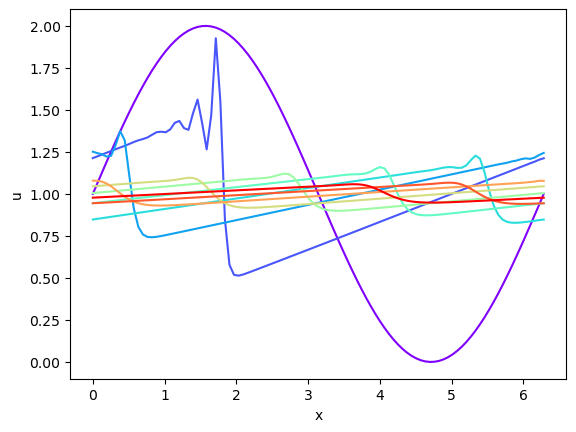

Text(0, 0.5, 'x')

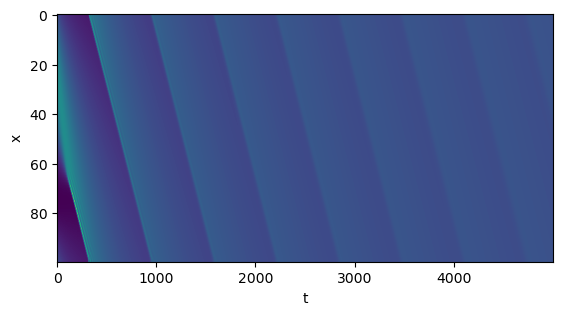

In [20]:
class BurgersEquation:
    """A class implementing Burgers' equation
    
    Parameters
        x (np.ndarray): The coordinates of the domain points
        t (np.ndarray): The timepoints at which to calculate the solution
        u0 (np.ndarray): The initial value of the speed variable across space at t=0
        nu (float): The value of the viscousity, which damps out the shocks
    
    """

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

    def _derivative(self, u):
        du = u.copy()

        # Vectorized central finite difference by shifting the array forwards/backwards
        du[1:-1] = (u[2:] - u[:-2]) / (2 * self.dx)

        ## Periodic boundary conditions
        du[0] = (u[1] - u[-1]) / self.dx
        du[-1] = (u[0] - u[-2]) / self.dx

        ## clamped (Dirichlet) boundary conditions
        # du[0] = (u[1] - 0) / self.dx
        # du[-1] = (0 - u[-1]) / self.dx

        ## Reflection (Neumann) boundary conditions
        # du[0] = 0
        # du[-1] = 0

        return du

    def _laplacian(self, u):
        ddu = u.copy()

        # Vectorized second order central finite difference by shifting the array 
        # forwards/backwards twice
        ddu[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / self.dx**2

        # Periodic boundary conditions
        ddu[0] = (u[1] - 2 * u[0] + u[-1]) / self.dx**2
        ddu[-1] = (u[0] - 2 * u[-1] + u[-2]) / self.dx**2

        ## Reflection (Neumann) boundary conditions
        # ddu[0] = (u[1] - 2 * u[0] + u[1]) / self.dx**2
        # ddu[-1] = (u[-2] - 2 * u[-1] + u[-2]) / self.dx**2

        ## clamped (Dirichlet) boundary conditions
        # ddu[0] = (u[1] - 2 * u[0] + 0) / self.dx**2
        # ddu[-1] = (0 - 2 * u[0] + u[-1]) / self.dx**2

        return ddu

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)


n_mesh = 100 # We set this hyperparameter, which decides the fineness of our mesh
# n_mesh = 30
x = np.linspace(0, 2 * np.pi, n_mesh) # Initial x vector
t = np.linspace(0, 50, 800) # 
u0 = 1 + np.sin(x) # Initial field value at all x points

# u0 = 1 - np.cos(x) # need to pick an initial condition consistent with boundary conditions

eq = BurgersEquation(x, t, u0, nu=1e-2)

# from scipy.integrate import solve_ivp
# sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t)
sol =  RK4(dt=1e-2).integrate(eq, (t[0], t[-1]), u0)

# plot with colormap for time
plt.figure()
colors = plt.cm.rainbow(np.linspace(0, 1, len(sol.y[::500])))
for i, sol0 in enumerate(sol.y[::500]):
    plt.plot(x, sol0, color=colors[i])
plt.xlabel('x')
plt.ylabel('u')
plt.show()

plt.figure()
plt.imshow(sol.y.T)
fixed_aspect_ratio(1/2)
plt.xlabel('t')
plt.ylabel('x')
# plt.colorbar(label='u(x, t)')
# plt.show()


## Explore the behavior of this PDE 

1. Try playing with the parameters $\nu$ and $\Delta x$ to see how the solution evolves. What causes the shocks to live longer?
2. Try changing the initial condition to a Gaussian. What happens?
3. Try changing the boundary conditions to reflective (Neumann) or Dirichlet. What happens?
4. What happens as we change the timestep $\Delta t$ or the number of mesh points $N_{mesh}$

## The CFL condition for hyperbolic PDEs

+ The Courant–Friedrichs–Lewy (CFL) condition is a condition on mesh size and the time step that must be satisfied for the numerical solution of a hyperbolic PDE to be stable
+ Suppose that we have the wave equation in one dimension:

$$\frac{\partial^2 \rho}{\partial t^2} = c^2 \frac{\partial^2 \rho}{\partial x^2}$$

where $c$ determines the speed of travelling waves. A full discretization of this equation in space and time would be

$$\frac{\rho(x, t + \Delta t) - 2 \rho(x, t) + \rho(x, t - \Delta t)}{\Delta t^2} = c^2 \frac{\rho(x + \Delta x, t) - 2 \rho(x, t) + \rho(x - \Delta x, t)}{\Delta x^2}$$

The CFL condition determines the maximum value of $\Delta t$ that can be used for a given $\Delta x$ and $c$

$$
c \frac{\Delta t}{\Delta x} \leq C_{max}
$$

+ Where the dimensionless Courant number $C_{max} \sim 1$ is determined by our iteration scheme. 
+ $C_{max}$ can be interpreted as the number of mesh cells that a particle of $\rho$ traverses per integration time step (for an Euler time-stepping scheme and fixed mesh size, this is exact). Realistically, we want to stay a little bit below the CFL limit, because we don't want to be right on the edge of instability. A typical "safety factor" would be $0.7$
+ A relative of the CFL condition is the Neumann condition for parabolic (diffusive) PDE: $ D (\Delta t) / (\Delta x)^2 \sim 1$

More info to check out in Chris Rycroft's notes: additional work showing stability conditions for PDE solvers. Fourier modes on a finite mesh, stability occurs  when none of the modes grow exponentially with time. Extremely similar to analytical tools that people use to study Reaction-Diffusion equations (see Murray textbook vol II, chapter 3).

## Applying the CFL condition to Burgers' equation

+ While we typically use the CFL condition here for hyperbolic PDE (wave equations), in practice it's a good rule-of-thumb for PDEs that admit travelling solutions, like solitons or Fisher waves or advance. 
+ Can find $c$ by defining the shape $u(x)$ of your solution wave, and then plugging the travelling solution $u(x - ct)$ into the PDE and solving for $c$
+ For Burgers' equation, we can pick a well-defined speed $c$ associated with the shock. For our parameter choices above, $c \approx 3$.

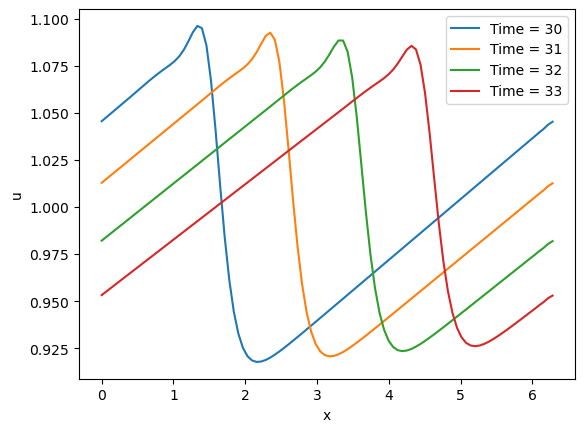

In [25]:
# plot with colormap for time
plt.figure()
colors = plt.cm.rainbow(np.linspace(0, 1, 3))
for t in [30, 31, 32, 33]:
    sol_ind = np.argmin(np.abs(sol.t - t))
    plt.plot(x, sol.y[sol_ind], label=f"Time = {t}")
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

It looks like our fronts travel about $1$ spatial unit per time unit, and so we estimate that the relevant speed scale $c = 1$

If we set $N_{mesh} = 300$, then $\Delta x = \pi / 150$ and the CFL condition tells us that $\Delta t < \Delta x / c$, or that $\Delta t <  \pi / 150 \approx 0.02$

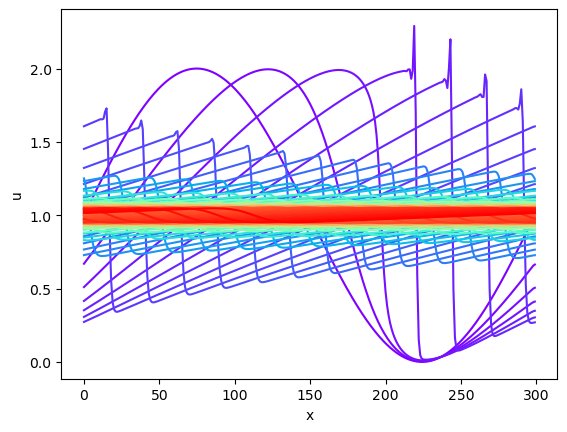

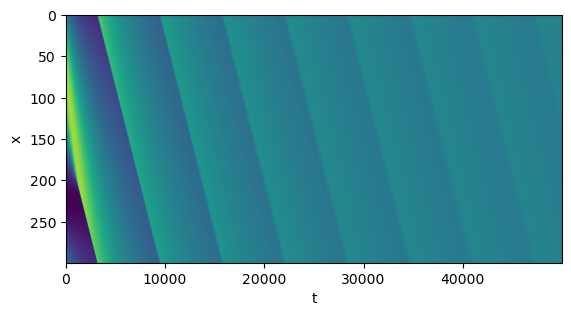

In [29]:
n_mesh = 300
x = np.linspace(0, 2 * np.pi, n_mesh)
u0 = 1 + np.sin(x)
dtval = 0.001
# dtval = 0.02
# dtval = 0.06
# dtval = 0.1
t = np.arange(0, 50, dtval)

eq = BurgersEquation(x, t, u0)

# integrator = RK4(dt=dtval)
# sol = integrator.integrate(eq, (t[0], t[-1]), u0, t_eval=t)
sol =  RK4(dt=dtval).integrate(eq, (t[0], t[-1]), u0)


# plot with colormap for time
colors = plt.cm.rainbow(np.linspace(0, 1, len(sol.y[::500])))
for i, sol0 in enumerate(sol.y[::500]):
    plt.plot(sol0, color=colors[i])
plt.xlabel('x')
plt.ylabel('u')
plt.show()

plt.imshow(sol.y.T)
fixed_aspect_ratio(1/2)
plt.xlabel('t')
plt.ylabel('x')
plt.show()



In [101]:
## Calculate CFL condition
c = 1 # wave speed
## Maximum timestep 
print('CFL maximum timestep: ', 3 * eq.dx / c)

CFL maximum timestep:  0.06304199304862461


# Burgers' equation in the spectral basis

+ Recall that our central idea is to convert PDEs into a series of coupled ODES, and then solve this separately. Discretizing space is one way to do this, but we are free to pick other transformations.

+ An alternative is to discretized our field by projecting it onto a series of basis functions $\phi_k(x)$

+ Our ODEs after discretization will discribe the time evolution of the relative amplitudes of these basis functions

<!-- ## FIX -->
Our original equation is

$$
\frac{\partial \rho}{\partial t} = \nu \frac{\partial^2 \rho}{\partial x^2} - \rho \frac{\partial \rho}{\partial x}
$$


Let's define a set of Fourier basis functions,

<!-- $$\phi_k(x) = \sqrt{\frac{2}{L}} \sin \left( \frac{2 \pi k x}{L} \right)$$ -->
$$\phi_k(x) = \exp(i k x)$$

where the angular wavenumber $k$ parametrizes the basis set. If our domain is $[0, L]$, then the values of $k$ become a countable set of frequencies that satisfy the periodic boundary conditions, $k = \frac{2 \pi n}{L}$. The Fourier basis functions are orthonormal, so we can write the solution as a linear combination of the basis functions

$$\rho(x, t) = \sum_{k = -\infty}^{\infty} c_k(t) \phi_k(x)$$

where $c_k(t)$ is the amplitude of the $k$ th Fourier mode at time $t$. We can next recall our rules for the Fourier transform of the derivatives of a function, in order to write the derivatives of the solution in terms of the amplitudes of the Fourier modes

$$\frac{\partial \rho}{\partial x} = \sum_{k = -\infty}^{\infty} i k c_k(t) \phi_k(x)$$

$$\frac{\partial^2 \rho}{\partial x^2} = \sum_{k = -\infty}^{\infty} -k^2 c_k(t) \phi_k(x)$$

<!-- We can use these to write the semi-discretized Burgers' equation in terms of the amplitudes of the Fourier modes

$$\frac{\partial c_k}{\partial t} = -\nu k^2 c_k$$ -->

Upon substituting these terms into the Burgers' equation PDE, we notice that the nonlinear term is a bit more involved

$$\sum_{k = -\infty}^{\infty} \dfrac{\partial c_k(t)}{\partial t} \phi_k(x) = -\nu \sum_{k = -\infty}^{\infty} k^2 c_k(t) \phi_k(x) - \bigg( \sum_{\ell = -\infty}^{\infty} c_\ell(t) \phi_\ell(x)\bigg)\sum_{k = -\infty}^{\infty} i k c_k(t) \phi_k(x)$$

If diffusion dominates the dynamics (or $\nu \gg 1$), then we would be able to split this equation term-by-term into a set of coupled ODEs in continuous time

$$\frac{\partial c_k}{\partial t} = -\nu k^2 c_k$$

For linear equations like the heat equation, the solution method is extremely simple: convert to the spectral domain, determine the time evolution of the coefficients $c_k(t)$, and then convert back to the physical domain. The modes of the heat equation are decoupled in the spectral domain, so we can solve the ODEs for each mode independently and very efficiently.

# Spectral methods with nonlinear terms

For nonlinear systems like Burgers' equation or reaction-diffusion equations, it's often not possible to convert the entire PDE into a concise spectral form. Instead, we need to "roundtrip" the solution between the physical and spectral domains at every evaluation. This is a bit more complicated, but it's still possible to solve the problem efficiently.

<!-- The semi-discretized PDE is now

$$\frac{\partial \rho_k}{\partial t} = \nu \frac{\partial^2 \rho_k}{\partial x^2}$$

which is a set of coupled ODEs in continuous time. We can solve this using a built-in ODE solver. -->

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_74519/3973866358.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = self.update(f, t_sol[i - 1], y[i - 1])


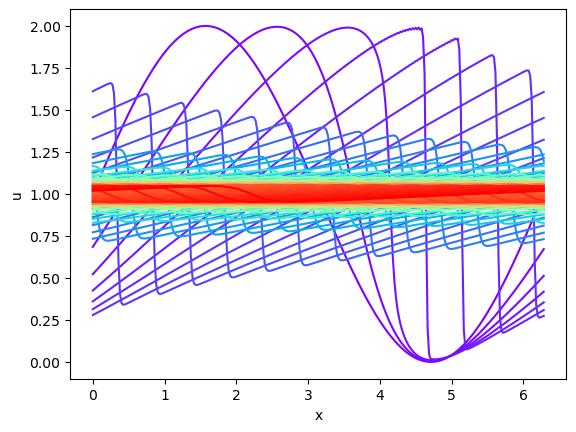

Text(0, 0.5, 'x')

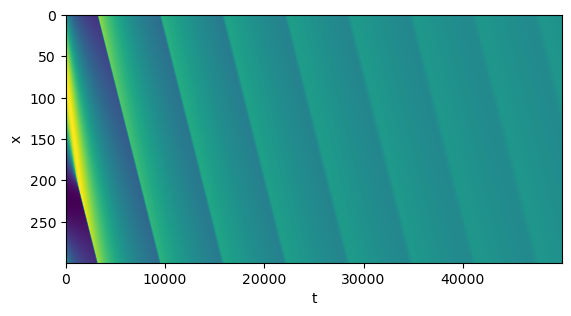

In [7]:
class BurgersEquationSpectral:
    """An implementation of the Burgers' equation using spectral methods."""

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

        self.k = 2 * np.pi * np.fft.fftfreq(len(x), d=self.dx)
        self.k[0] = 1e-16 # avoid division by zero

    def _derivative(self, u):
        return np.fft.ifft(1j * self.k * np.fft.fft(u))

    def _laplacian(self, u):
        return np.fft.ifft(-self.k**2 * np.fft.fft(u))

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)



x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 800)
u0 = 1 + np.sin(x)

eq = BurgersEquationSpectral(x, t, u0)


dtval = 0.001
sol =  RK4(dt=dtval).integrate(eq, (t[0], t[-1]), u0)

# plot with colormap for time
plt.figure()
colors = plt.cm.rainbow(np.linspace(0, 1, len(sol.y[::500])))
for i, sol0 in enumerate(sol.y[::500]):
    plt.plot(x, sol0, color=colors[i])
plt.xlabel('x')
plt.ylabel('u')
plt.show()

plt.figure()
plt.imshow(sol.y.T)
fixed_aspect_ratio(1/2)
plt.xlabel('t')
plt.ylabel('x')
# plt.show()

# from scipy.integrate import solve_ivp
# sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t, max_step=0.01)

# plot with colormap for time
# colors = plt.cm.rainbow(np.linspace(0, 1, len(sol.y[:, ::100].T)))
# for i, sol0 in enumerate(sol.y[:, ::100].T):
#     plt.plot(x, sol0, color=colors[i])
# plt.show()


# plt.imshow(sol.y)
# fixed_aspect_ratio(1/2)
# plt.xlabel('t')
# plt.ylabel('x')
# plt.show()




### Spectral methods as preconditioning

+ Recall that the convergence time of linear dynamical systems was related to the condition number of the matrix. That's because high-condition number matrices are closer to having degenerate column spaces, and thus act like lower-dimensional dynamical systems under repeated iterations

+ We can think of spectral methods as a way of preconditioning the system, by transforming the system into a basis where the condition number is lower. This is why spectral methods are so effective for linear partial differential equations. For nonlinear PDEs, the condition number of the system is not the only factor that determines the convergence time, but spectral transforms can sometimes allow us to solve the problem with larger timesteps

## What are the appropriate basis functions? 

+ Usually, we pick basis functions that form an orthogonal set, and which are consistent with our boundary conditions
+ So far, we've been using the Fourier basis functions and periodic boundary conditions


## The Chebyshev basis functions

+ For Dirichlet boundary conditions, we can use the Chebyshev basis functions, which are a set of functions that vanish or approach constant values at the boundary
+ The Chebyshev basis functions are a set of orthogonal functions that are defined on the interval $[-1, 1]$
+ The Chebyshev basis functions are defined recursively
$$T_0(x) = 1$$
$$T_1(x) = x$$
$$T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$$

## Legendre basis functions

+ Another option for Dirichlet boundary conditions, we can use the Chebyshev basis functions, which are a set of functions that vanish or approach constant values at the boundary
+ The Legendre basis functions are a set of orthogonal functions that are defined on the interval $[-1, 1]$
+ The Legendre basis functions are defined recursively
$$P_0(x) = 1$$
$$P_1(x) = x$$
$$P_{n+1}(x) = \frac{2n+1}{n+1}xP_n(x) - \frac{n}{n+1}P_{n-1}(x)$$




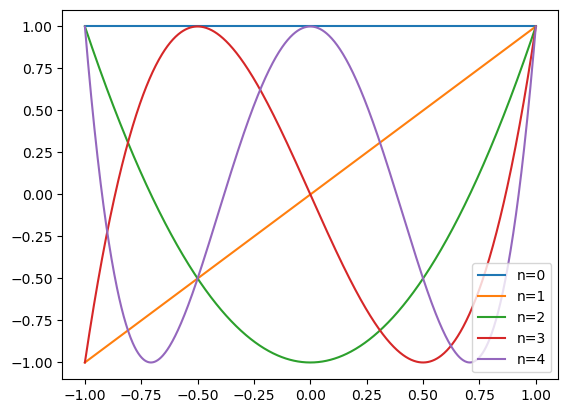

In [36]:
### Plot example Chebyshev polynomials

from scipy.special import eval_chebyt

x = np.linspace(-1, 1, 1000)
for n in range(5):
    plt.plot(x, eval_chebyt(n, x), label=f'n={n}')

plt.legend()
plt.show()


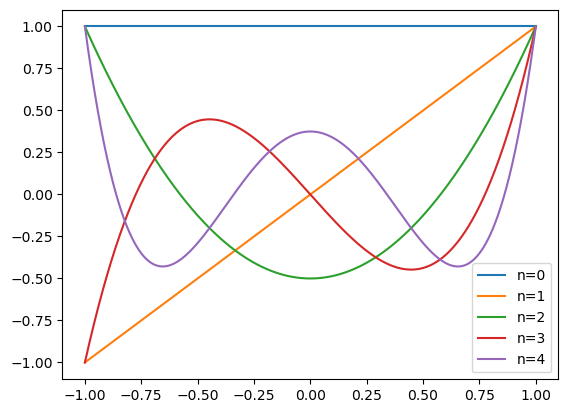

In [37]:
### Plot example Legendre polynomials

from scipy.special import eval_legendre

x = np.linspace(-1, 1, 1000)
for n in range(5):
    plt.plot(x, eval_legendre(n, x), label=f'n={n}')

plt.legend()
plt.show()



# Some specificities of Burgers' equation

+ Shock waves are discontinuities in the velocity, but not in the density
+ The shock wave is a discontinuity in the derivative of the velocity
+ Propagate ballistically, i.e. at a constant speed of sound in the fluid
+ Characteristics: initial conditions get "carried" with the flow


### An even easier solution approach: Transformation onto a linear equation

+ Burgers equation is a nonlinear PDE, but it can be transformed into a linear PDE by introducing a new variable

The Cole-Hopf transformation implies that we can substitute the variable $u(x)$ with $\phi(x)$ using the following defintion
$$
u=-2\nu {\frac {1}{\phi }}{\frac {\partial \phi }{\partial x}}
$$

Inserting this into the viscous Burgers equation gives
$$
{\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial \phi }{\partial t}}\right)=\nu {\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial ^{2}\phi }{\partial x^{2}}}\right)
$$
After some algebraic manipulation, we get
$$
{\frac {\partial \phi }{\partial t}}=\nu {\frac {\partial ^{2}\phi }{\partial x^{2}}}
$$
This is a linear diffusion equation, which can easily be solved in one dimension. We can solve this simplified heat equation, and then cast back into the original variables by performing the inverse transformation

$$
u(x,t)=-2\nu {\frac {1}{\phi }}{\frac {\partial \phi }{\partial x}}
$$


#### Takeaway: unlike our chaotic systems, the complexity of the dynamics of the Burgers equation is not intrinsic, but rather due to our choice of dynamical variables

+ Preview of machine learning: is a problem intrinsically hard, or do we just need to pick the right coordinates?

## Appendix

+ This is William's leftover code, which might get used in a future version of the tutorial

In [ ]:
# Solve the KuramotoSivashinsky equation with spectral methods

from scipy.integrate import solve_ivp

class KuramotoSivashinskyEquationSpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


In [ ]:
# https://scicomp.stackexchange.com/questions/37336/solving-numerically-the-1d-kuramoto-sivashinsky-equation-using-spectral-methods
class KuramotoSivashinskySpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]
        self.dt = t[1] - t[0]

        self.k = np.fft.fftfreq(len(x), d=self.dx)
        self.k2 = self.k**2
        self.k4 = self.k**4

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

eq = KuramotoSivashinskySpectral(x, t, u0)
sol = eq.solve()

plt.plot(x, sol[:, 0])
plt.plot(x, sol[:, -1])
plt.show()
